Neural networks are built with layers connected to each other. There are many different kind of layers. For image related applications, you can always find convolutional layers. It is a layer with very few parameters but applied over a large sized input. It is powerful because it can preserve the spatial structure of the image. Therefore it is used to produce state-of-the-art results on computer vision neural networks. In this post, you will learn about the convolutional layer and the network it built. After completing this post, you will know:

* What are convolutional layers and pooling layers
* How they fit together in a neural network
* How a neural network using convolutional layers is designed

# The case for CNNs

Let’s consider to make a neural network to process grayscale image as input, which is the simplest use case in deep learning for computer vision.

A grayscale image is an array of pixels. Each pixel is usually a value in a range of 0 to 255. An image with size 32×32 would have 1024 pixels. Taking it as input to a neural network would mean the first layer to have at least 1024 input weights.

Looking at the pixel value has little use to understanding the picture, because data is hiding in the spatial structure (e.g., whether there is a horizontal line or a vertical line on the picture). Hence the traditional neural network will find it difficult to find out information from image input.

Convolutional neural network is to use convolutional layers to preserve spatial information of pixels. It learns how alike are the neighboring pixels and generating **feature representations**. What the convolutional layers see from the picture is invariant to distortion in some degree. For example, a convolutional neural network could predict the same result even if the input image has shift in color, rotated or rescaled. Moreover, convolutional layers has fewer weights, thus easier to train.

# Building Blocks of CNNs

The simplest use case of a convolutional neural network is for classification. You will find it to contain three types of layers:

1. Convolutional layers
2. Pooling layers
3. Fully-connected layers

Neurons on a convolutional layer is called the filter. Usually it is a 2D convolutional layer in image application. The filter is a 2D patch (e.g., 3x3 pixels) that is applied on the input image pixels. The size of this 2D patch is also called the receptive field, meaning how large a portion of the image it can see at a time.

The filter of a convolutional layer is to multiply with the input pixels, and then sum up the result. This result is one pixel value at the output. The filter will move around the input image to fill out all pixel values at the output. Usually multiple filters are applied to the same input, producing multiple output tensors. These output tensors are called the **feature maps** produced by this layer. They are stacked together as one tensor and pass on to the next layer as input.

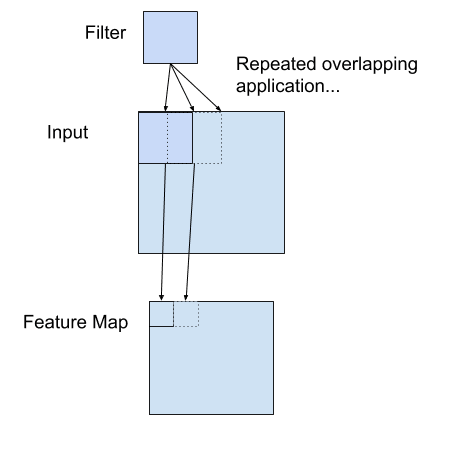

The output of a convolutional layer is called feature maps because usually it learned about the features of the input image. For example, whether there are vertical lines at the position. Learning the features from pixels is to help understanding the image at a higher level. Multiple convolutional layers are stacked together in order to infer higher level features from lower level details.

Pooling layer is to **downsample** the previous layer's feature map. It is usually used after a convolutional layer to consolidate features learned. It can compress and generalize the feature representations. A pooling layer also has a receptive field and usually it is to take the average (average pooling) or the maximum (max pooling) over all values on the receptive field.

Fully connected layers are usually the final layers in a network. It is to take the features consolidated by previous convolutional and pooling layers as input to produce prediction. There might be multiple fully connected layers stacked together. In the case of classification, you usually see the output of the final fully connected layer applied with a softmax function to produce probability-like classification.

# An example of CNN

The following is a program to do image classification on the CIFAR-10 dataset.

The CIFAR-10 dataset provides images in 32x32 pixels in RGB color (i.e., 3 color channels). There are 10 classes, labelled in integers 0 to 9. Whenever you are working on PyTorch neural network models for images, you will find the sister library torchvision useful. In the above, you used it to download the CIFAR-10 dataset from the Internet and transform it into a PyTorch tensor:

In [2]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch

In [6]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# get the training and test set of CIFAR10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# get the training and test data
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
class CIFAR10Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
    self.act1 = nn.ReLU()
    self.drop1 = nn.Dropout(0.3)

    self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

    self.flat = nn.Flatten()

    self.fc3 = nn.Linear(8192, 512)
    self.act3 = nn.ReLU()
    self.drop3 = nn.Dropout(0.5)

    self.fc4 = nn.Linear(512, 10)

  def forward(self, x):
    # input 3x32x32, output 32x32x32
    x = self.act1(self.conv1(x))
    x = self.drop1(x)
    # input 32x32x32, output 32x32x32
    x = self.act2(self.conv2(x))
    # input 32x32x32, output 32x16x16
    x = self.pool2(x)
    # input 32x16x16, output 8192
    x = self.flat(x)
    # input 8192, output 512
    x = self.act3(self.fc3(x))
    x = self.drop3(x)
    # input 512, output 10
    x = self.fc4(x)
    return x

In [8]:
import numpy as np

model = CIFAR10Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

n_epochs = 20
for epoch in range(n_epochs):
  losses = []
  for inputs, labels in trainloader:
    # forward, backward, and then weight update
    y_pred = model(inputs)
    loss = loss_fn(y_pred, labels)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch {epoch + 1} --> loss = {np.mean(losses)}')

  acc = 0
  count = 0
  for inputs, labels in testloader:
    y_pred = model(inputs)
    acc += (torch.argmax(y_pred, 1) == labels).float().sum()
    count += len(labels)
  acc /= count
  print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

torch.save(model.state_dict(), "cifar10model.pth")

Epoch 1 --> loss = 1.9856032800460883
Epoch 0: model accuracy 36.43%
Epoch 2 --> loss = 1.7121244325747647
Epoch 1: model accuracy 41.97%
Epoch 3 --> loss = 1.5934709643066807
Epoch 2: model accuracy 45.20%
Epoch 4 --> loss = 1.5152867400943661
Epoch 3: model accuracy 47.85%
Epoch 5 --> loss = 1.4453453876159166
Epoch 4: model accuracy 48.43%
Epoch 6 --> loss = 1.3825932019655323
Epoch 5: model accuracy 51.46%
Epoch 7 --> loss = 1.3276697946754084
Epoch 6: model accuracy 53.31%
Epoch 8 --> loss = 1.2854246676006305
Epoch 7: model accuracy 54.15%
Epoch 9 --> loss = 1.2449636901713912
Epoch 8: model accuracy 54.54%
Epoch 10 --> loss = 1.2024790367405915
Epoch 9: model accuracy 56.04%
Epoch 11 --> loss = 1.1629956057265411
Epoch 10: model accuracy 56.45%
Epoch 12 --> loss = 1.1193533547398988
Epoch 11: model accuracy 57.66%
Epoch 13 --> loss = 1.0834532766027933
Epoch 12: model accuracy 58.15%
Epoch 14 --> loss = 1.0462868268567633
Epoch 13: model accuracy 59.03%
Epoch 15 --> loss = 1.007

It is typical in a network for image classification to be comprised of convolutional layers at an early stage, with dropout and pooling layers interleaved. Then, at a later stage, the output from convolutional layers is flattened and processed by some fully connected layers.

# What are in Feature Maps?

There are two convolutional layers in the network defined above. They are both defined with kernel size of 3x3, hence it is looking at 9 pixels at a time to produce one output pixel. Note that the first convolutional layer is taking the RGB image as input. Hence each pixel has three channels. The second convolutional layer is taking a feature map with 32 channels as input. Each “pixel” as it sees will have 32 values. Thus the second convolutional layer has more parameters even they have the same receptive field.

Let's see what is in the feature map. Let's say we pick one input sample from the training set:

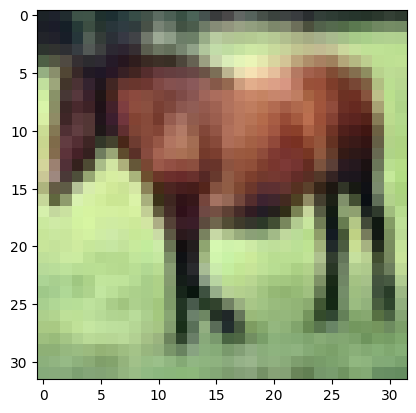

In [9]:
import matplotlib.pyplot as plt

plt.imshow(trainset.data[7])
plt.show()

First, you need to convert this into a PyTorch tensor and make it a batch of one image. PyTorch models expect each image as a tensor in the format of (channel, height, width) but the data you read is in the format of (height, width, channel). If you use torchvision to transform the image into PyTorch tensors, this format conversion is done automatically. Otherwise, you need to **permute** the dimensions before use.

Afterward, pass it on through the model's first convolution layer and capture the output. You need to tell PyTorch that no gradient is needed for this calculation as you are not going to optimize the model weight:

In [11]:
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2)
model.eval()
with torch.no_grad():
  feature_maps = model.conv1(X)

The feature maps are in one tensor. You can visualize them using matplotlib:



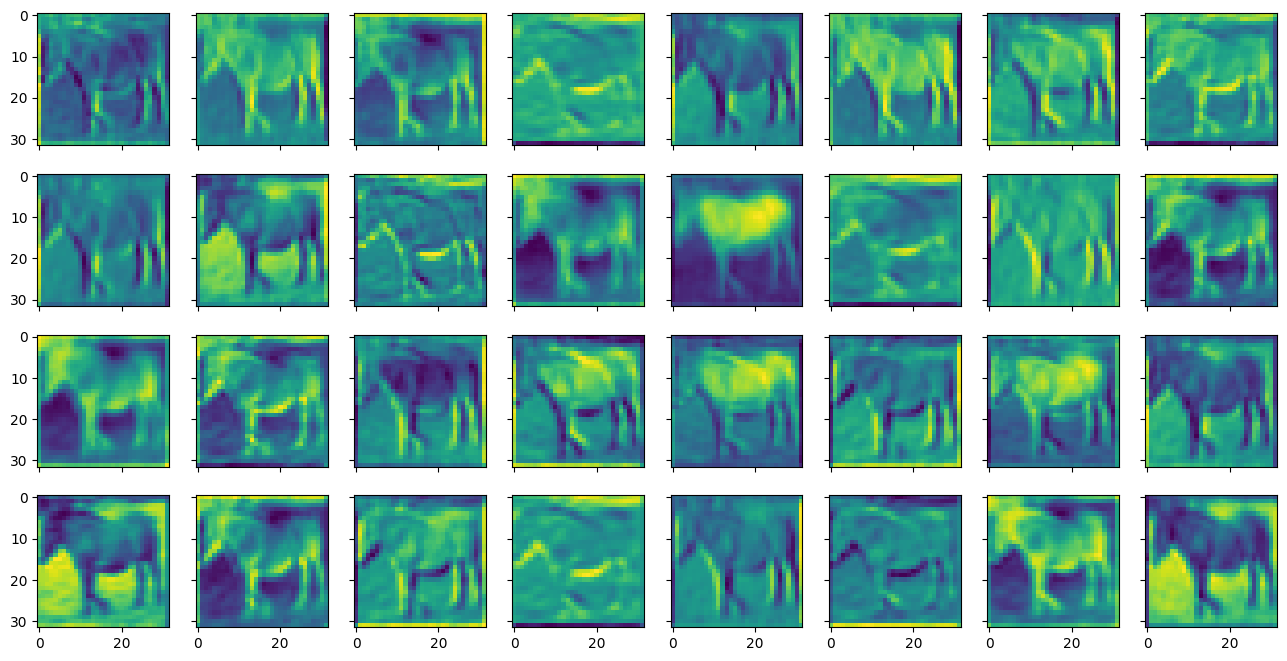

In [12]:
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
  row, col = i//8, i%8
  ax[row][col].imshow(feature_maps[0][i])
plt.show()

You can see that they are called feature maps because they are highlighting certain features from the input image. A feature is identified using a small window (in this case, over a 3x3 pixels filter). The input image has three color channels. Each channel has a different filter applied, and their results are combined for an output feature.

You can similarly display the feature map from the output of the second convolutional layer as follows:

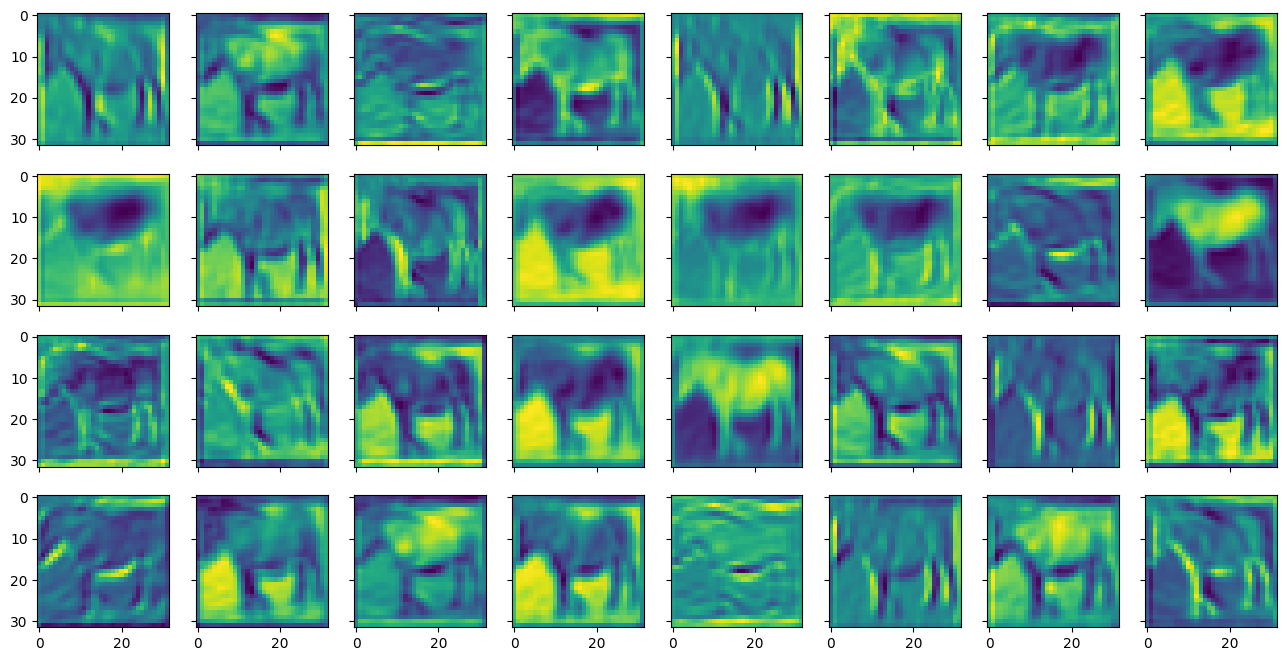

In [13]:
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2)

model.eval()
with torch.no_grad():
  feature_maps = model.act1(model.conv1(X))
  feature_maps = model.drop1(feature_maps)
  feature_maps = model.conv2(feature_maps)

fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
  row, col = i//8, i%8
  ax[row][col].imshow(feature_maps[0][i])
plt.show()

Compared to the output of the first convolutional layer, the feature maps from the second convolutional layer looks blurry and more abstract. But these are more useful for the model to identify the objects.